In [378]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np

In [379]:
df = pd.read_csv("s3://german-credit-22/Datos/original/german_credit_data.csv", index_col=0)

In [380]:
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Risk"])

In [381]:
features = ['Age', 'Credit amount', 'Duration', 'Sex', 'Purpose', 'Housing']

In [382]:
numeric_pipeline = Pipeline(
    [
        ('Imputación con la media', SimpleImputer(strategy='mean')),
        ('Escalado minmax', MinMaxScaler())
    ]
)

In [383]:
categorical_pipeline = Pipeline(
    [
        ("Imputacion con la Moda", SimpleImputer(strategy='most_frequent')),
        ("Codificación OneHot", OneHotEncoder(sparse=False))
    ]
)

In [384]:
column_transformer = ColumnTransformer(
    [
        ("numeric_pipeline", numeric_pipeline, [0,1,2]),
        ("categorical_pipeline", categorical_pipeline, [3,4,5])
    ]
)

## Selección de carasteristicas

### Preprocesamiento

In [385]:
#train = train.dropna()

In [386]:
X_train = train.drop("Risk", axis=1)

In [387]:
y_train = train["Risk"]

In [388]:
y_train = (y_train=='good').astype('int')

In [389]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 328 to 617
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               700 non-null    int64 
 1   Sex               700 non-null    object
 2   Job               700 non-null    int64 
 3   Housing           700 non-null    object
 4   Saving accounts   575 non-null    object
 5   Checking account  426 non-null    object
 6   Credit amount     700 non-null    int64 
 7   Duration          700 non-null    int64 
 8   Purpose           700 non-null    object
dtypes: int64(4), object(5)
memory usage: 54.7+ KB


In [390]:
X_train['Saving accounts'].value_counts()

little        428
moderate       78
quite rich     36
rich           33
Name: Saving accounts, dtype: int64

In [391]:
X_train = pd.get_dummies(X_train)

X_train

### Seleccion de Caracteristicas con Arbol Decisión

In [392]:
model = DecisionTreeClassifier()

In [393]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [394]:
model.feature_importances_

array([0.12461137, 0.0315237 , 0.28664538, 0.16716172, 0.01269841,
       0.03938988, 0.01981931, 0.00946746, 0.01984127, 0.03518417,
       0.        , 0.00304332, 0.        , 0.06747871, 0.04923547,
       0.00694638, 0.01761003, 0.01496599, 0.        , 0.01486732,
       0.03406035, 0.04230601, 0.00314375, 0.        ])

In [395]:
X_train.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male',
       'Housing_free', 'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others'],
      dtype='object')

In [396]:
dict_features = {}
for nombre, coef_gini in zip(X_train.columns, model.feature_importances_):
    dict_features[nombre] = coef_gini

In [397]:
ordered_columns = X_train.columns[np.flip(np.argsort(model.feature_importances_))]

In [398]:
ordered_importance = np.flip(np.sort(model.feature_importances_))

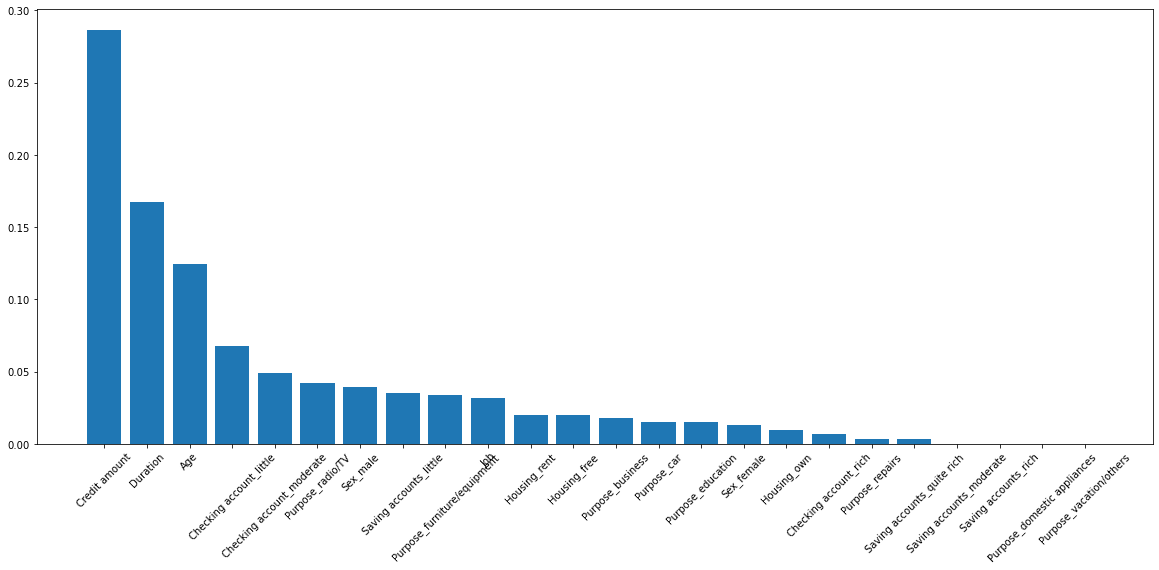

In [399]:
plt.figure(figsize=(20,8)) 
plt.bar(x=ordered_columns,
       height=ordered_importance)
plt.xticks(rotation=45)
plt.show()

### Selección de Caracteristicas con Regresión Logística

In [400]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [401]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)

In [402]:
model = LogisticRegression()

In [403]:
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [404]:
model.coef_

array([[ 0.835423  ,  0.22589944, -0.84641275, -1.65275004, -0.17648599,
         0.17627164, -0.06978226,  0.19162547, -0.12205756, -0.75798873,
        -0.61445739, -0.0168324 ,  0.4072842 , -1.58304637, -1.21149862,
        -0.53892366, -0.02147902,  0.10660812,  0.06698805, -0.61955824,
         0.21115495,  0.55444807, -0.22076645, -0.07760984]])

In [405]:
lg_ordered_columns = X_train.columns[np.flip(np.argsort(model.coef_))]

/tmp/ipykernel_6937/94092939.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg_ordered_columns = X_train.columns[np.flip(np.argsort(model.coef_))]


In [406]:
lg_ordered_importance = np.flip(np.sort(model.coef_))[0]

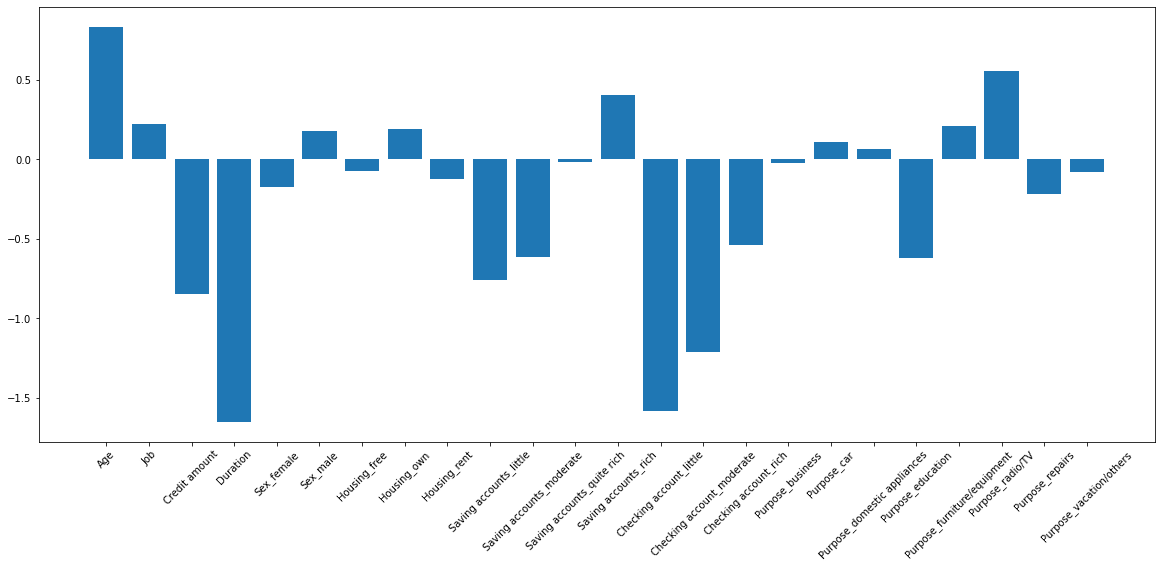

In [407]:
plt.figure(figsize=(20,8)) 
plt.bar(x=X_train.columns,
       height=model.coef_[0])
plt.xticks(rotation=45)
plt.show()

## Evaluación de modelos

### Validación Cruzada

### Decision Tree

In [408]:
final_pipeline = Pipeline(
    [
        ("Pipeline de preprocesamiento", column_transformer),
        ("Modelo de predicción (Árbol)", DecisionTreeClassifier(max_depth=4))
    ]
)

In [409]:
X_trainf_final = train[features]

In [410]:
results = cross_validate(final_pipeline,
                        X_trainf_final, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

In [411]:
print("train: ", results['train_accuracy'].mean(), "+-", results["train_accuracy"].std())
print("validation: ", results['test_accuracy'].mean(), "+-", results["test_accuracy"].std())

train:  0.7595238095238095 +- 0.004559176703601622
validation:  0.7171428571428571 +- 0.023733211036908786


### Logistic Regression

In [412]:
final_pipeline_lr = Pipeline(
    [
        ("Pipeline de preprocesamiento", column_transformer),
        ("Modelo de predicción (Árbol)", LogisticRegression())
    ]
)

In [413]:
X_trainf_lr = train[features]

In [414]:
results_lr = cross_validate(final_pipeline_lr,
                        X_trainf_lr, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

In [415]:
print("train: ", results_lr['train_accuracy'].mean(), "+-", results_lr["train_accuracy"].std())
print("validation: ", results_lr['test_accuracy'].mean(), "+-", results_lr["test_accuracy"].std())

train:  0.7233333333333334 +- 0.00355286179136497
validation:  0.7185714285714286 +- 0.026380264732313422


### Random Forest

In [416]:
from sklearn.ensemble import RandomForestClassifier

In [417]:
final_pipeline_rf = Pipeline(
    [
        ("Pipeline de preprocesamiento", column_transformer),
        ("Modelo de predicción (Árbol)", RandomForestClassifier(max_depth=3))
    ]
)

In [418]:
X_trainf_rf = train[features]

results_rf = cross_validate(final_pipeline_rf,
                        X_trainf_rf, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

In [420]:
print("train: ", results_rf['train_accuracy'].mean(), "+-", results_rf["train_accuracy"].std())
print("validation: ", results_rf['test_accuracy'].mean(), "+-", results_rf["test_accuracy"].std())

train:  0.7279365079365079 +- 0.0041513323271815976
validation:  0.7142857142857143 +- 0.015649215928719037


### Support Vector Machines

In [421]:
from sklearn.svm import SVC

In [422]:
final_pipeline_svm = Pipeline(
    [
        ("Pipeline de preprocesamiento", column_transformer),
        ("Modelo de predicción (Árbol)", SVC())
    ]
)

In [423]:
X_trainf_svm = train[features]

In [424]:
results_svm = cross_validate(final_pipeline_svm,
                        X_trainf_svm, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

In [425]:
print("train: ", results_svm['train_accuracy'].mean(), "+-", results_svm["train_accuracy"].std())
print("validation: ", results_svm['test_accuracy'].mean(), "+-", results_svm["test_accuracy"].std())

train:  0.7284126984126985 +- 0.004679175546978951
validation:  0.7085714285714285 +- 0.011428571428571436


### Multilayer Perceptron

In [429]:
from sklearn.neural_network import MLPClassifier

In [451]:
final_pipeline_mlp = Pipeline(
    [
        ("Pipeline de preprocesamiento", column_transformer),
        ("Modelo de predicción (Árbol)", MLPClassifier(hidden_layer_sizes=(100, 3), max_iter=500))
    ]
)

In [452]:
X_trainf_mlp = train[features]

In [453]:
results_mlp = cross_validate(final_pipeline_mlp,
                        X_trainf_mlp, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [454]:
print("train: ", results_mlp['train_accuracy'].mean(), "+-", results_mlp["train_accuracy"].std())
print("validation: ", results_mlp['test_accuracy'].mean(), "+-", results_mlp["test_accuracy"].std())

train:  0.7838095238095237 +- 0.006459361888690709
validation:  0.6985714285714286 +- 0.04446966404649536


## Ajuste de HiperParámetros

### Modelo Seleccionado: RandomForest

In [462]:
from sklearn.model_selection import GridSearchCV

In [463]:
grid = {'max_depth': [2,3,5,10], 'n_estimators': [50, 100, 200]}

In [474]:
#Preprocesar ya que no se puede pasar el pipeline al gridsearch
X_transformed = column_transformer.fit_transform(X_train)

In [475]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid=grid,
    cv=10,
    scoring="accuracy"
)

In [476]:
grid_search.fit(X_transformed, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [477]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [478]:
grid_search.best_score_

0.7171428571428572

In [481]:
grid_search.cv_results_

{'mean_fit_time': array([0.09979942, 0.11636205, 0.22510152, 0.06191468, 0.11585536,
        0.23340554, 0.06183233, 0.12160976, 0.24425964, 0.06832285,
        0.13690217, 0.27076013]),
 'std_fit_time': array([0.06003062, 0.00542911, 0.00175168, 0.00460733, 0.0016139 ,
        0.01024451, 0.00154399, 0.00186299, 0.00776998, 0.0012834 ,
        0.00521328, 0.00823   ]),
 'mean_score_time': array([0.00922935, 0.0088429 , 0.01600459, 0.00517118, 0.00833259,
        0.01589103, 0.00468869, 0.00852087, 0.01608458, 0.00483623,
        0.0092442 , 0.01708624]),
 'std_score_time': array([0.00780084, 0.00100151, 0.00034649, 0.00115916, 0.00010809,
        0.00014976, 0.00029397, 0.00018953, 0.00014076, 0.00011675,
        0.00066901, 0.00025716]),
 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 5, 5, 5, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=obj

## Modelo Final

### Randon Forest: {'max_depth': 10, 'n_estimators': 50}

In [482]:
final_pipeline_bestmodel = Pipeline(
    [
        ("Pipeline de preprocesamiento", column_transformer),
        ("Modelo de predicción (Árbol)", RandomForestClassifier(max_depth=10, n_estimators=50))
    ]
)

In [483]:
X_train_best_model = train[features]

In [484]:
final_pipeline_bestmodel.fit(X_train_best_model, y_train)

Pipeline(steps=[('Pipeline de preprocesamiento',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('Imputación '
                                                                   'con la '
                                                                   'media',
                                                                   SimpleImputer()),
                                                                  ('Escalado '
                                                                   'minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2]),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('Imputacion '
                                                                   'con la '
                          

In [ ]:
import 

In [485]:
joblib.dump(final_pipeline_bestmodel, 'final_model.joblib')

NameError: name 'joblib' is not defined